In [6]:
%%markdown
# ✈️ IV. Air Traffic Analysis  
## 🔍 Trends and Forecast
**Objective:** Evaluate air traffic growth and seasonality, to see if using a Supervised Technique is useful to predict airflights in the following periods.

# ✈️ IV. Air Traffic Analysis  
## 🔍 Trends and Forecast
**Objective:** Evaluate air traffic growth and seasonality, to see if using a Supervised Technique is useful to predict airflights in the following periods.


In [ ]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
!pip install pmdarima
from sklearn.model_selection import train_test_split
from pmdarima.arima import auto_arima

In [ ]:
import pandas as pd
# Load the dataset
df=pd.read_excel("Airport_Traffic.xlsx")

STEP TO IDENTIFY THE 5 MORE IMPORTANT AIRPORTS (HIGHEST TRAFFIC)

In [ ]:
# Cargar el dataset COMPLETO
df = pd.read_excel("Airport_Traffic.xlsx", sheet_name="DATA")

# Agrupar por aeropuerto y sumar el tráfico total IFR (llegadas + salidas)
top_airports_df = df.groupby(["APT_ICAO", "APT_NAME"])["FLT_TOT_1"].sum().reset_index()

# Ordenar de mayor a menor tráfico total
top_airports_df = top_airports_df.sort_values(by="FLT_TOT_1", ascending=False)

# Mostrar los 3 aeropuertos con más tráfico
top_airports_df.head(5)

##Los 5 aeropuertos con mayor tráfico en la muestra de datos son:
#Frankfurt Airport (EDDF) - Alemania
#London Heathrow (EGLL) - Reino Unido
#Amsterdam Schiphol (EHAM) - Países Bajos
#Paris Charles de Gaulle (LFPG) - Francia
#Madrid Barajas (LEMD) - España


In [17]:
# Cargar el dataset con TOP 5
import pandas as pd  

# Cargar el dataset con TOP 5 aeropuertos  
df = pd.read_csv("Selected_Airports.csv")   


In [19]:
df

,YEAR,MONTH,APT_ICAO,APT_NAME,FLT_DEP_1,FLT_ARR_1,FLT_TOT_1,DATE
0,2016,1,EDDF,Frankfurt,17176,17113,34289,2016-01-01
1,2016,1,EGLL,London - Heathrow,18608,18583,37191,2016-01-01
2,2016,1,EHAM,Amsterdam - Schiphol,16987,16977,33964,2016-01-01
3,2016,1,LEMD,Madrid - Barajas,14366,14336,28702,2016-01-01
4,2016,1,LFPG,Paris-Charles-de-Gaulle,17829,17806,35635,2016-01-01
...,...,...,...,...,...,...,...,...
540,2025,1,EDDF,Frankfurt,15496,15434,30930,2025-01-01
541,2025,1,EGLL,London - Heathrow,19452,19450,38902,2025-01-01
542,2025,1,EHAM,Amsterdam - Schiphol,18396,18392,36788,2025-01-01
543,2025,1,LEMD,Madrid - Barajas,16913,16918,33831,2025-01-01


In [113]:
# Convertir la columna de fecha a tipo datetime
df["FLT_DATE"] = pd.to_datetime(df["DATE"], errors="coerce")

# Crear una tabla agregada mensual
df_monthly = df.groupby(
    ["YEAR", "MONTH", "APT_ICAO", "APT_NAME"]
)[["FLT_DEP_1", "FLT_ARR_1", "FLT_TOT_1"]].sum().reset_index()

# Renombrar columnas para claridad
df_monthly = df_monthly.rename(columns={"MONTH_NUM": "MONTH"})

# Crear una columna de fecha con el primer día de cada mes
df_monthly["DATE"] = pd.to_datetime(df_monthly.assign(DAY=1)[["YEAR", "MONTH", "DAY"]])

# Definir los aeropuertos que queremos conservar
top_airports = ["EHAM", "LFPG", "EDDF"]

# Filtrar los datos para estos aeropuertos
df_selected_airports = df_monthly[df_monthly["APT_ICAO"].isin(top_airports)].copy()

# Asegurar que las fechas sean el índice de la serie temporal
df_selected_airports.set_index("DATE", inplace=True)

# Mostrar las primeras filas para verificar
print(df_selected_airports.head())


            YEAR  MONTH APT_ICAO                 APT_NAME  FLT_DEP_1  \
DATE                                                                   
2016-01-01  2016      1     EDDF                Frankfurt      17176   
2016-01-01  2016      1     EHAM     Amsterdam - Schiphol      16987   
2016-01-01  2016      1     LFPG  Paris-Charles-de-Gaulle      17829   
2016-02-01  2016      2     EDDF                Frankfurt      17050   
2016-02-01  2016      2     EHAM     Amsterdam - Schiphol      16895   

            FLT_ARR_1  FLT_TOT_1  
DATE                              
2016-01-01      17113      34289  
2016-01-01      16977      33964  
2016-01-01      17806      35635  
2016-02-01      17041      34091  
2016-02-01      16892      33787  


In [115]:
df_selected_airports

,YEAR,MONTH,APT_ICAO,APT_NAME,FLT_DEP_1,FLT_ARR_1,FLT_TOT_1
DATE,,,,,,,
2016-01-01,2016,1,EDDF,Frankfurt,17176,17113,34289
2016-01-01,2016,1,EHAM,Amsterdam - Schiphol,16987,16977,33964
2016-01-01,2016,1,LFPG,Paris-Charles-de-Gaulle,17829,17806,35635
2016-02-01,2016,2,EDDF,Frankfurt,17050,17041,34091
2016-02-01,2016,2,EHAM,Amsterdam - Schiphol,16895,16892,33787
...,...,...,...,...,...,...,...
2024-12-01,2024,12,EHAM,Amsterdam - Schiphol,19292,19286,38578
2024-12-01,2024,12,LFPG,Paris-Charles-de-Gaulle,19269,19285,38554
2025-01-01,2025,1,EDDF,Frankfurt,15496,15434,30930


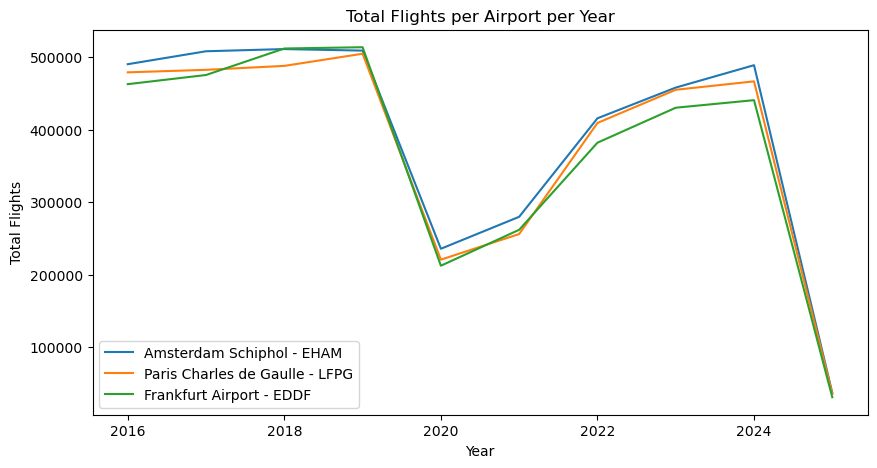

In [121]:
import matplotlib.pyplot as plt

#Mapeo de códigos de aeropuertos a nombres completos
airport_labels = {
   "EHAM": "Amsterdam Schiphol - EHAM",
   "LFPG": "Paris Charles de Gaulle - LFPG",
   "EDDF": "Frankfurt Airport - EDDF",
}

plt.figure(figsize=(10, 5))

# Graficar cada aeropuerto con su etiqueta correspondiente
for airport, label in airport_labels.items():
    subset = total_flights_by_airport_year[total_flights_by_airport_year["APT_ICAO"] == airport]
    plt.plot(subset["YEAR"], subset["FLT_TOT_1"], label=label)

plt.xlabel("Year")
plt.ylabel("Total Flights")
plt.title("Total Flights per Airport per Year")
plt.legend()

# Guardar la imagen con alta calidad
plt.savefig("total_flights_per_airport.png", dpi=300, bbox_inches="tight")

# Mostrar la gráfica
plt.show()



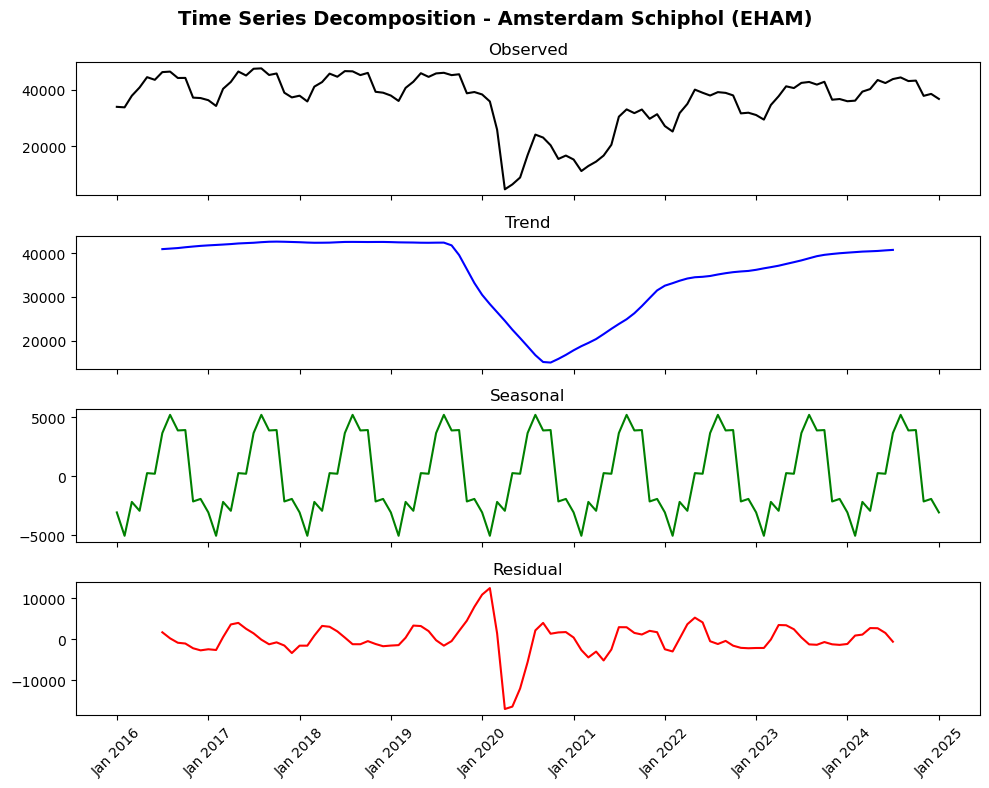

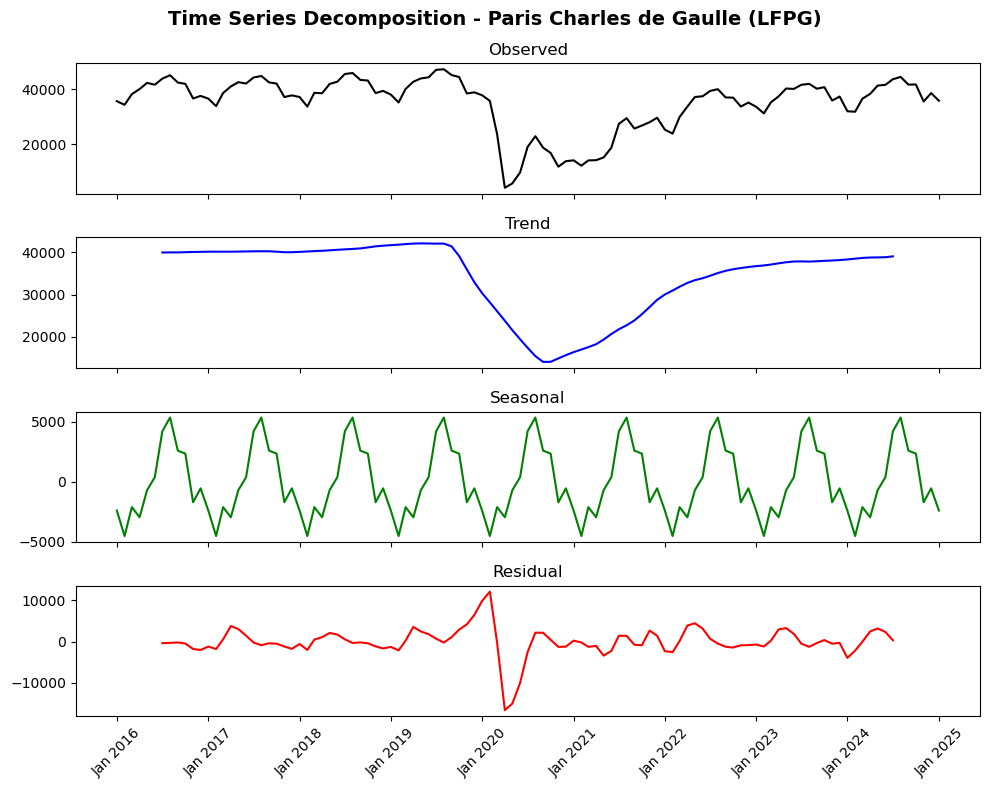

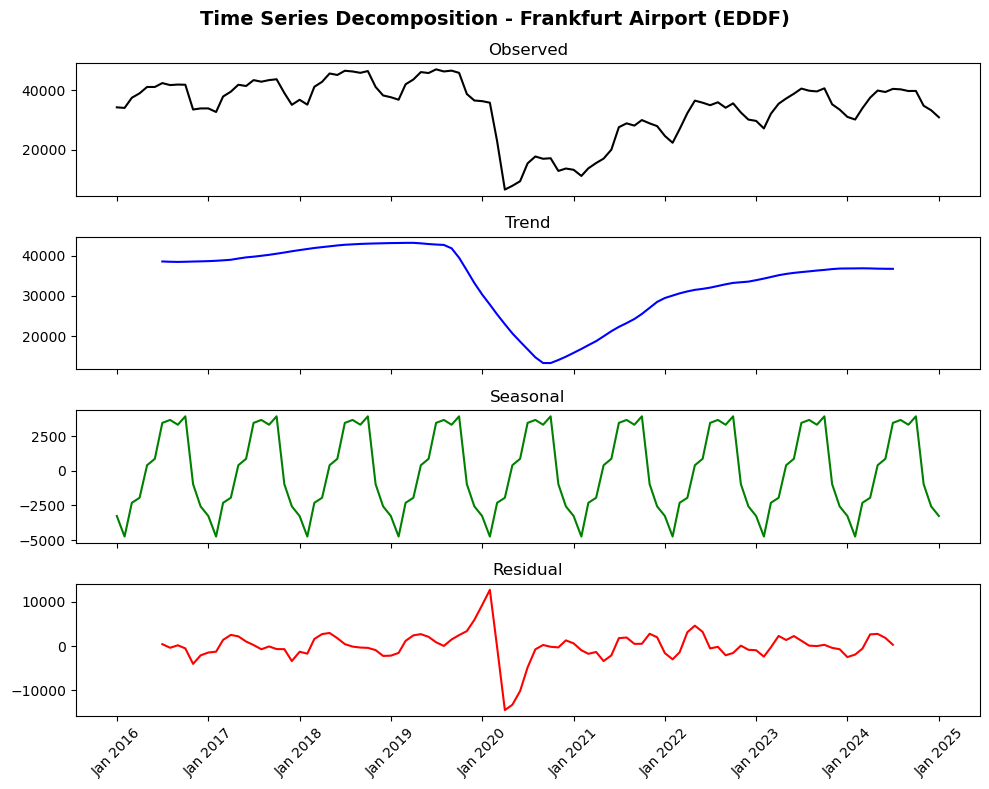

In [127]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import seasonal_decompose

# Análisis para cada aeropuerto
for airport_code in top_airports:
    df_airport = df_selected_airports[df_selected_airports["APT_ICAO"] == airport_code][["FLT_TOT_1"]].copy()
    
    # --- 1. Time Series Decomposition ---
    decomposition = seasonal_decompose(df_airport["FLT_TOT_1"], model="additive", period=12)
    
    # --- 2. Graphics ---
    fig, axes = plt.subplots(4, 1, figsize=(10, 8), sharex=True)
    fig.suptitle(f'Time Series Decomposition - {airport_names[airport_code]} ({airport_code})', 
                 fontsize=14, weight="bold")
    
    # Observed
    axes[0].plot(df_airport.index, decomposition.observed, color='black', linewidth=1.5)
    axes[0].set_title("Observed", fontsize=12)
    
    # Trend
    axes[1].plot(df_airport.index, decomposition.trend, color='blue', linewidth=1.5)
    axes[1].set_title("Trend", fontsize=12)

    # Seasonal
    axes[2].plot(df_airport.index, decomposition.seasonal, color='green', linewidth=1.5)
    axes[2].set_title("Seasonal", fontsize=12)

    # Residual
    axes[3].plot(df_airport.index, decomposition.resid, color='red', linewidth=1.5)
    axes[3].set_title("Residual", fontsize=12)
    
    # Format X 
    axes[3].xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))  # '%b' da el nombre abreviado del mes
    plt.xticks(rotation=45)
    
    plt.tight_layout()

    # Save the graphics for report
    plt.savefig(f"decomposition_{airport_code}.png", dpi=300)  # Puedes cambiar el nombre del archivo y el formato

    # Show graphics
    plt.show()



Processing forecast for Amsterdam Schiphol - EHAM...
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=1681.812, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1681.071, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1676.319, Time=0.07 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1677.515, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1679.077, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1679.653, Time=0.05 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=1677.483, Time=0.19 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=1676.562, Time=0.27 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=1677.058, Time=0.07 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=1678.527, Time=0.21 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=1678.903, Time=0.06 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=1678.131, Time=0.08 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=1678.233, Time=0.09 sec
 ARIMA(0,1,1)(1,0,0)[12] interce

C:\Users\MSI Prestige\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\MSI Prestige\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\MSI Prestige\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


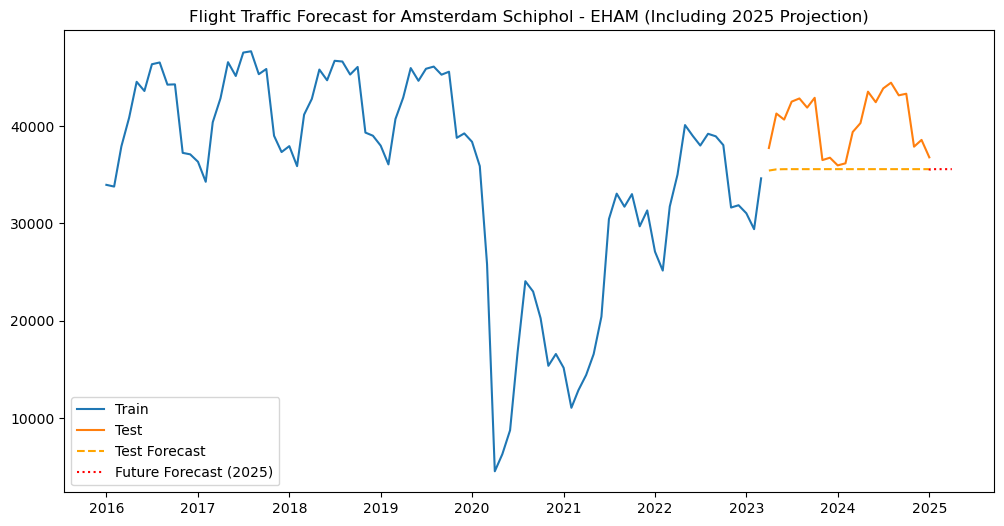

Forecast plot saved as forecast_EHAM.png

Processing forecast for Paris Charles de Gaulle - LFPG...
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=1670.668, Time=0.56 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1667.294, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1664.631, Time=0.15 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1665.167, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1665.300, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1666.571, Time=0.06 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=1666.107, Time=0.21 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=1665.677, Time=0.24 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=1665.058, Time=0.10 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=1667.639, Time=0.48 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=1666.256, Time=0.09 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=1666.544, Time=0.14 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=1666.579, 

C:\Users\MSI Prestige\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\MSI Prestige\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\MSI Prestige\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


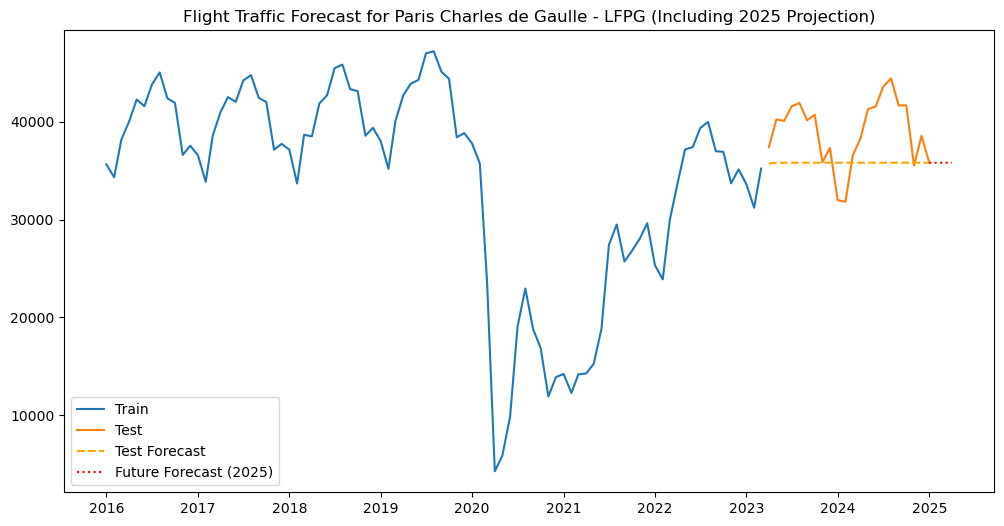

Forecast plot saved as forecast_LFPG.png

Processing forecast for Frankfurt Airport - EDDF...
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=1657.796, Time=0.55 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1654.516, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1651.111, Time=0.09 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1651.704, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1652.526, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1652.105, Time=0.06 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=1652.861, Time=0.20 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=1652.331, Time=0.26 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=1651.353, Time=0.10 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=1.24 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=1654.186, Time=0.06 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=1652.980, Time=0.08 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=1653.006, Time=0.11 s

C:\Users\MSI Prestige\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\MSI Prestige\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\MSI Prestige\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast Accuracy for Frankfurt Airport - EDDF:
MAE: 4525.44, MSE: 27032229.71, RMSE: 5199.25

Forecast data saved as forecast_results_EDDF.csv


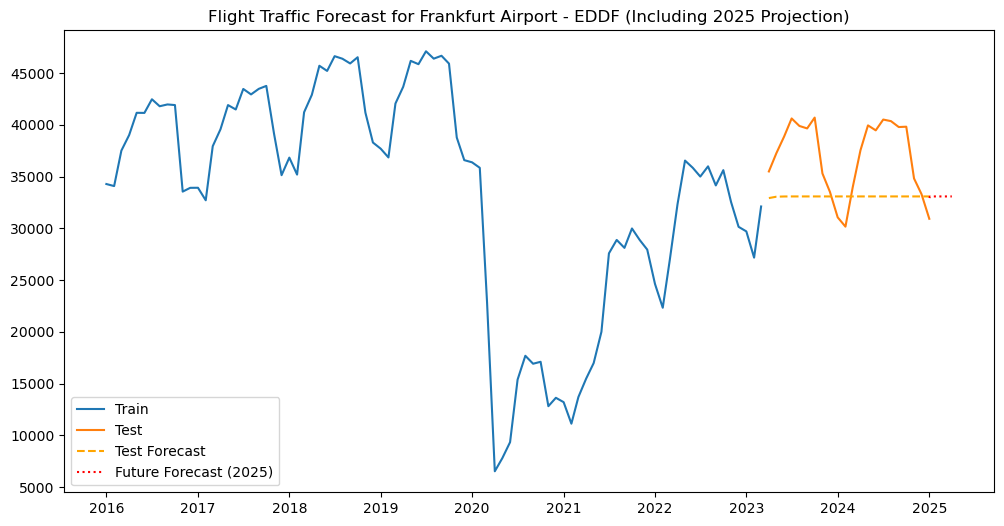

Forecast plot saved as forecast_EDDF.png

Processing forecast for London Heathrow - EGLL...
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=1652.314, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1645.270, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1646.319, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1646.483, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1643.276, Time=0.02 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=1645.493, Time=0.04 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=1645.390, Time=0.03 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1647.281, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1646.624, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=1646.738, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=1648.056, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12]          
Total fit time: 0.679 seconds
Forecast Accuracy for London Heathrow - EGLL:
MAE:

C:\Users\MSI Prestige\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\MSI Prestige\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\MSI Prestige\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


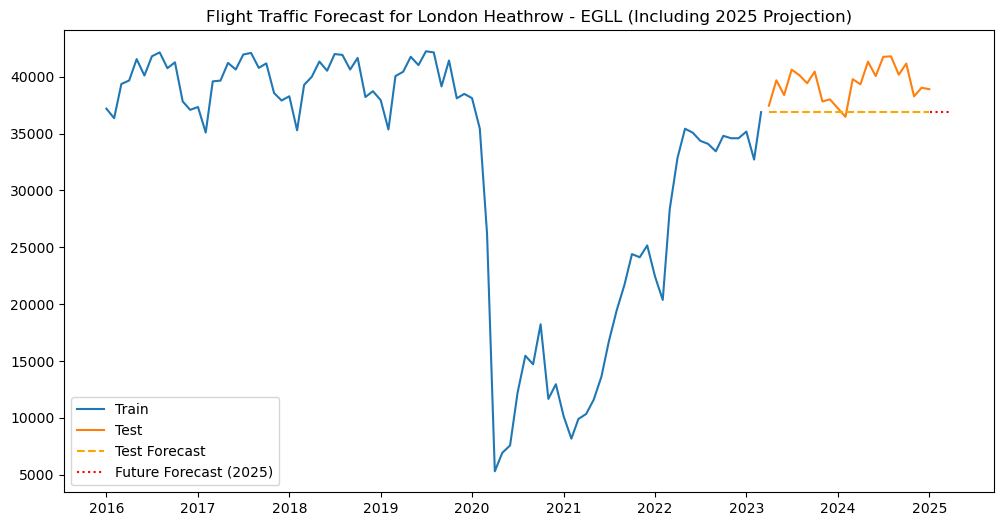

Forecast plot saved as forecast_EGLL.png

Processing forecast for Madrid Barajas - LEMD...
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=1631.058, Time=0.85 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1626.374, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1625.082, Time=0.12 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1625.529, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1624.389, Time=0.03 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=1627.545, Time=0.07 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=1627.522, Time=0.07 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1629.507, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1624.760, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=1625.133, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=1626.514, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12]          
Total fit time: 1.656 seconds


C:\Users\MSI Prestige\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\MSI Prestige\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\MSI Prestige\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast Accuracy for Madrid Barajas - LEMD:
MAE: 2974.36, MSE: 11821812.18, RMSE: 3438.29

Forecast data saved as forecast_results_LEMD.csv


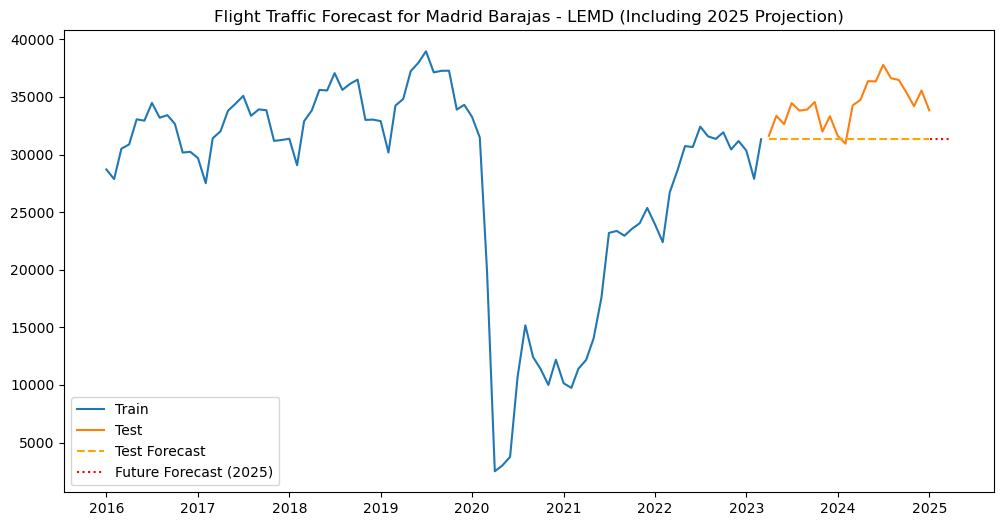

Forecast plot saved as forecast_LEMD.png


In [91]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Define the forecasting horizon (3 months = 90 days)
forecast_horizon = 90  

# Mapping of airport codes to full names
airport_labels = {
    "EHAM": "Amsterdam Schiphol - EHAM",
    "LFPG": "Paris Charles de Gaulle - LFPG",
    "EDDF": "Frankfurt Airport - EDDF",
}

# Loop through each airport in the selected list
for airport_code in top_airports:
    airport_name = airport_labels.get(airport_code, airport_code)  # Get full name or fallback to code
    print(f"\nProcessing forecast for {airport_name}...")

    # Filter data for the current airport
    df_airport = df_selected_airports[df_selected_airports["APT_ICAO"] == airport_code][["FLT_TOT_1"]].copy()

    # Split data into training (80%) and testing (20%)
    train, test = train_test_split(df_airport, test_size=0.2, shuffle=False)

    # Automatically select ARIMA parameters
    auto_model = auto_arima(train["FLT_TOT_1"], seasonal=True, m=12, trace=True, suppress_warnings=True)
    best_order = auto_model.order

    # Fit ARIMA model with the best parameters
    model = ARIMA(train["FLT_TOT_1"], order=best_order)
    model_fit = model.fit()

    # Forecast on the test set
    test_forecast = model_fit.forecast(steps=len(test))

    # Forecast for the next 3 months (90 days)
    future_forecast = model_fit.forecast(steps=forecast_horizon)

    # Create future dates for the forecast
    last_date = df_airport.index[-1]
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_horizon, freq="D")

    # Calculate error metrics
    mae = mean_absolute_error(test["FLT_TOT_1"], test_forecast)
    mse = mean_squared_error(test["FLT_TOT_1"], test_forecast)
    rmse = np.sqrt(mse)

    print(f'Forecast Accuracy for {airport_name}:')
    print(f'MAE: {mae:.2f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}\n')

    # Create DataFrame with forecast results (both test forecast and future forecast)
    forecast_df = pd.DataFrame({
        "Date": test.index.tolist() + future_dates.tolist(),
        "Actual Flights": list(test["FLT_TOT_1"].values) + [np.nan] * forecast_horizon,
        "Forecasted Flights": list(test_forecast) + list(future_forecast)
    })

    # Save forecast results to CSV
    forecast_csv_filename = f"forecast_results_{airport_code}.csv"
    forecast_df.to_csv(forecast_csv_filename, index=False)
    print(f"Forecast data saved as {forecast_csv_filename}")

    # Plot predictions
    plt.figure(figsize=(12, 6))
    plt.plot(train.index, train["FLT_TOT_1"], label="Train")
    plt.plot(test.index, test["FLT_TOT_1"], label="Test")
    plt.plot(test.index, test_forecast, label="Test Forecast", linestyle="dashed", color="orange")
    plt.plot(future_dates, future_forecast, label="Future Forecast (2025)", linestyle="dotted", color="red")
    plt.legend()
    plt.title(f'Flight Traffic Forecast for {airport_name} (Including 2025 Projection)')

    # Save the plot as an image
    forecast_image_filename = f"forecast_{airport_code}.png"
    plt.savefig(forecast_image_filename, dpi=300, bbox_inches="tight")

    # Show the plot
    plt.show()

    print(f"Forecast plot saved as {forecast_image_filename}")



In [ ]:
WE SEE THAT ARIMA IS NOT SO ACCURATED, IT LOSSES THE SEASONALITY, WE TRY WITH A SARIMA :)


Processing forecast for Amsterdam Schiphol - EHAM...


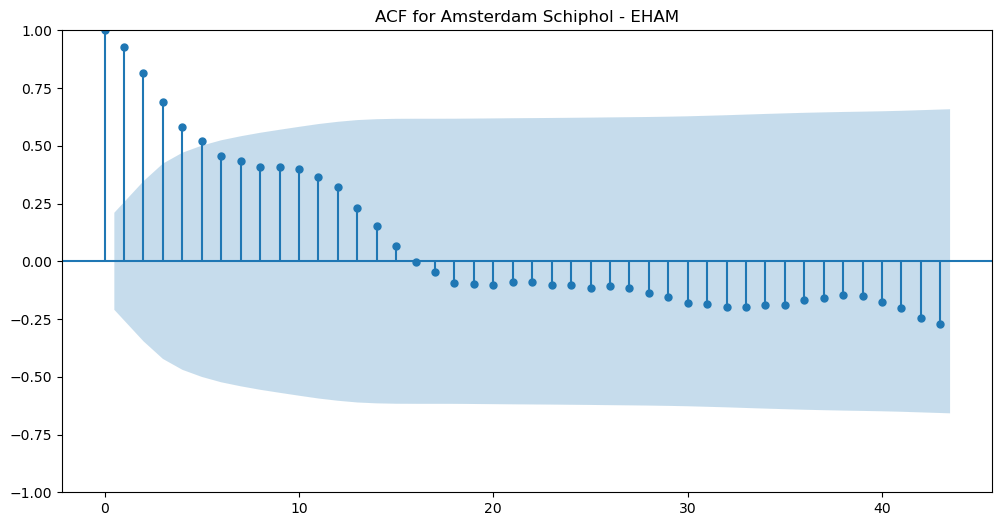

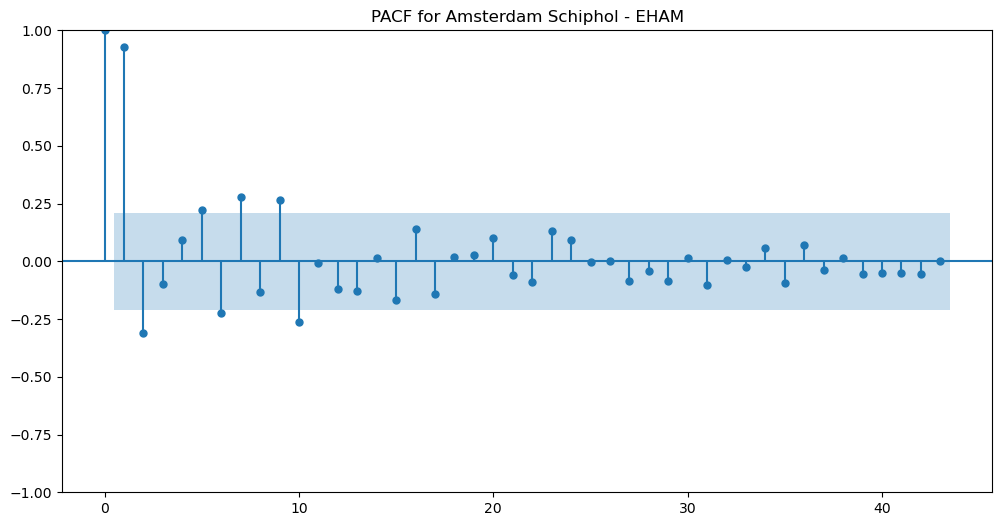

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=1681.812, Time=0.64 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1681.071, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1676.319, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1677.515, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1679.077, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1679.653, Time=0.05 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=1677.483, Time=0.22 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=1676.562, Time=0.25 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=1677.058, Time=0.09 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=1678.527, Time=0.51 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=1678.903, Time=0.10 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=1678.131, Time=0.13 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=1678.233, Time=0.16 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=1676.723, Time=0.11 sec
 ARIMA(2,1,1)(1,0,0

C:\Users\MSI Prestige\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\MSI Prestige\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


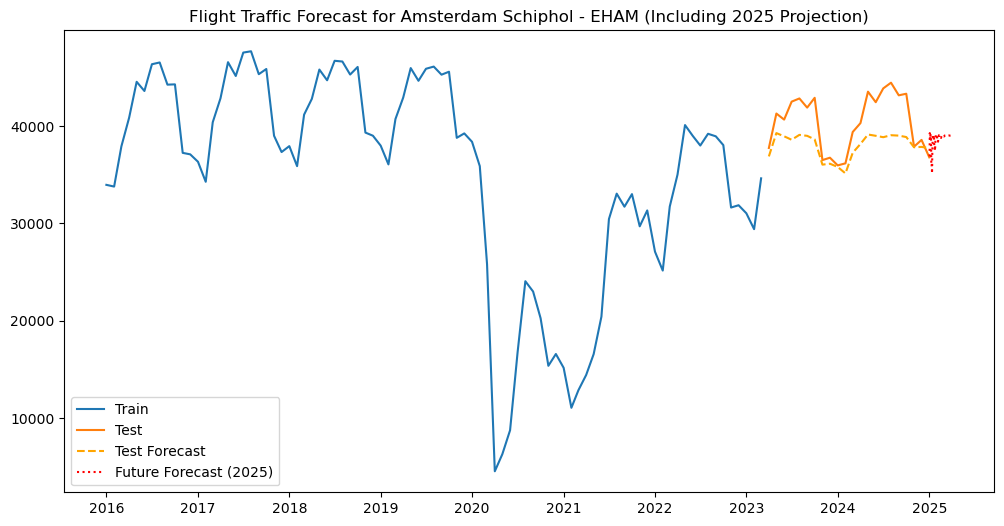

Forecast plot saved as forecast_EHAM.png

Processing forecast for Paris Charles de Gaulle - LFPG...


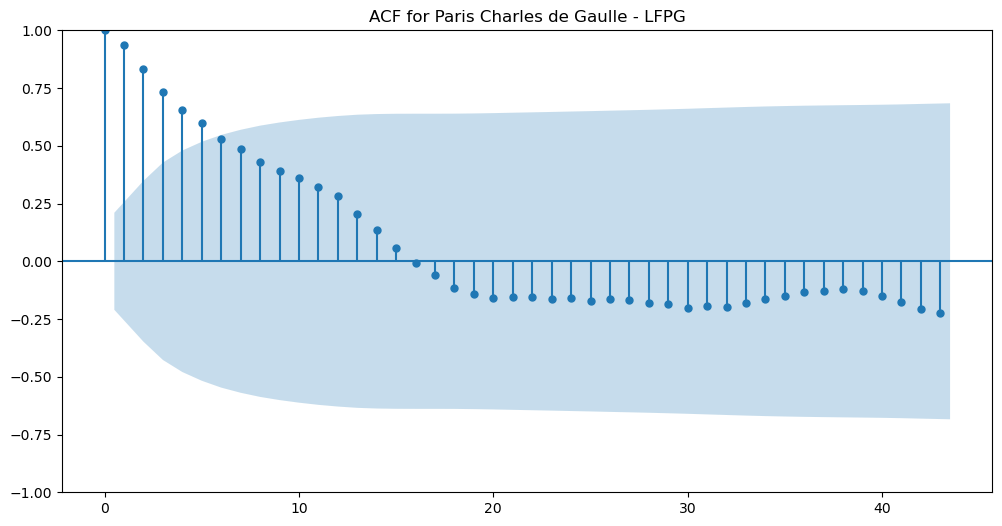

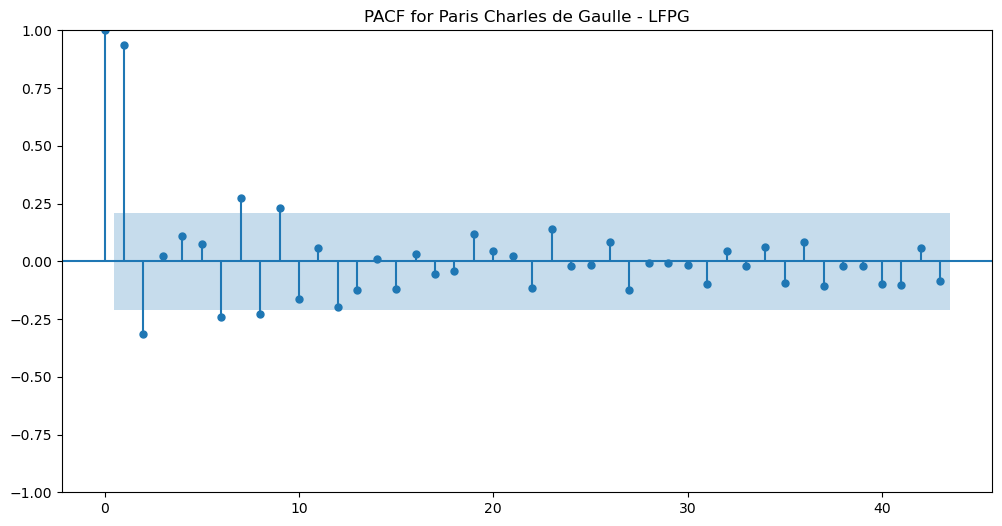

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=1670.668, Time=0.59 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1667.294, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1664.631, Time=0.21 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1665.167, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1665.300, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1666.571, Time=0.09 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=1666.107, Time=0.22 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=1665.677, Time=0.21 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=1665.058, Time=0.10 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=1667.639, Time=0.36 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=1666.256, Time=0.06 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=1666.544, Time=0.11 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=1666.579, Time=0.10 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=1664.702, Time=0.06 sec
 ARIMA(2,1,1)(1,0,0

C:\Users\MSI Prestige\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\MSI Prestige\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast Accuracy for Paris Charles de Gaulle - LFPG:
MAE: 2191.54, MSE: 6784594.35, RMSE: 2604.73

Forecast data saved as forecast_results_LFPG.csv


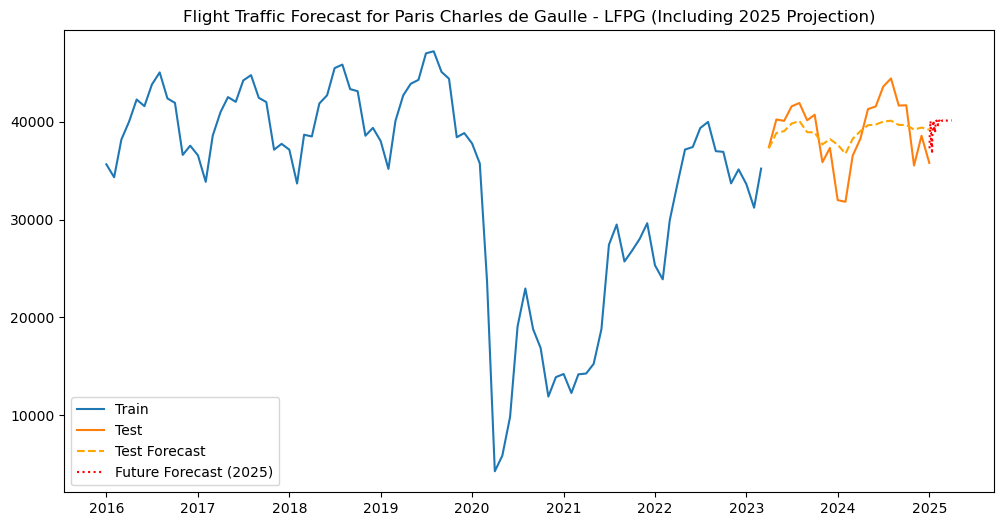

Forecast plot saved as forecast_LFPG.png

Processing forecast for Frankfurt Airport - EDDF...


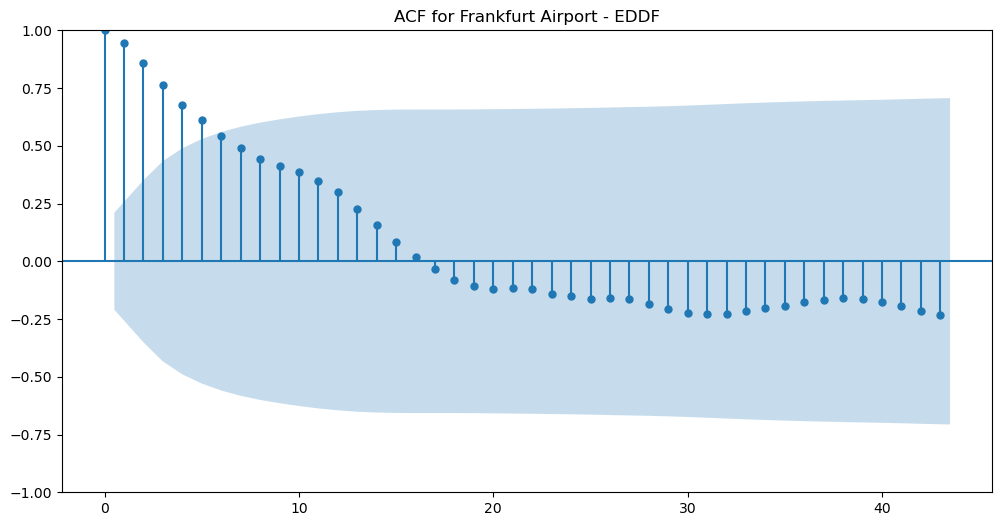

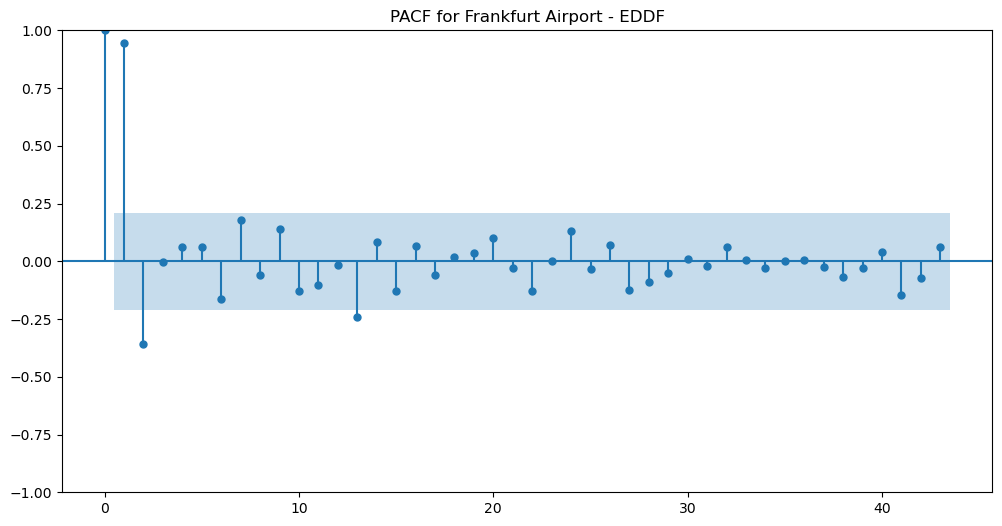

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=1657.796, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1654.516, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1651.111, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1651.704, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1652.526, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1652.105, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=1652.861, Time=0.10 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=1652.331, Time=0.18 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=1651.353, Time=0.06 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=1.16 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=1654.186, Time=0.08 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=1652.980, Time=0.14 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=1653.006, Time=0.17 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=1651.427, Time=0.10 sec
 ARIMA(2,1,1)(1,0,0)[12]

C:\Users\MSI Prestige\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\MSI Prestige\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


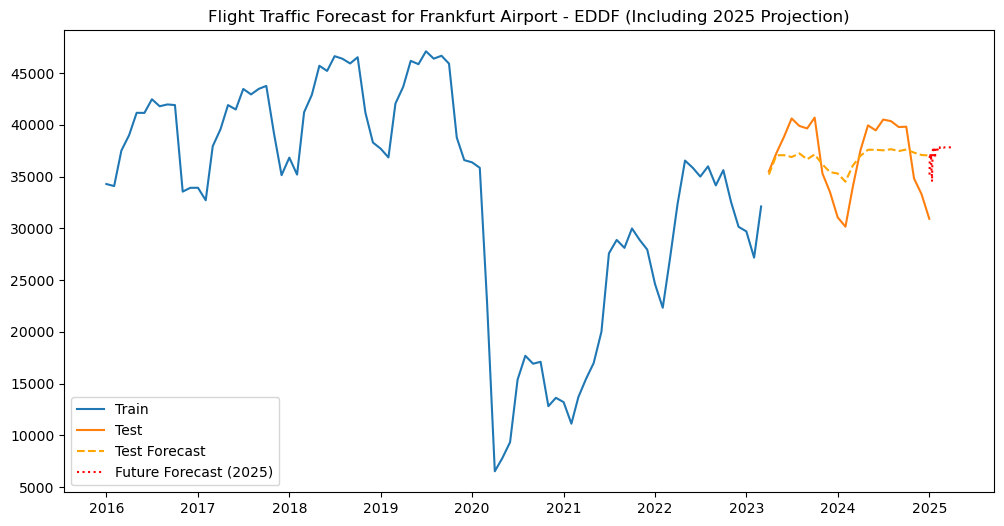

Forecast plot saved as forecast_EDDF.png


In [129]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Define the forecasting horizon (3 months = 90 days)
forecast_horizon = 90  

# Mapping of airport codes to full names
airport_labels = {
    "EHAM": "Amsterdam Schiphol - EHAM",
    "LFPG": "Paris Charles de Gaulle - LFPG",
    "EDDF": "Frankfurt Airport - EDDF",
}

# Loop through each airport in the selected list
for airport_code in top_airports:
    airport_name = airport_labels.get(airport_code, airport_code)  # Get full name or fallback to code
    print(f"\nProcessing forecast for {airport_name}...")

    # Filter data for the current airport
    df_airport = df_selected_airports[df_selected_airports["APT_ICAO"] == airport_code][["FLT_TOT_1"]].copy()

    # Split data into training (80%) and testing (20%)
    train, test = train_test_split(df_airport, test_size=0.2, shuffle=False)

    # Calculate the maximum number of lags for ACF and PACF (50% of the sample size)
    max_lags = len(train) // 2  # 50% of the sample size

    # Plot ACF with the calculated maximum lags
    plt.figure(figsize=(12, 6))
    plot_acf(train["FLT_TOT_1"], lags=max_lags, ax=plt.gca())
    plt.title(f'ACF for {airport_name}')
    plt.show()

    # Plot PACF with the calculated maximum lags
    plt.figure(figsize=(12, 6))
    plot_pacf(train["FLT_TOT_1"], lags=max_lags, ax=plt.gca())
    plt.title(f'PACF for {airport_name}')
    plt.show()

    # Automatically select SARIMA parameters with seasonal component
    auto_model = auto_arima(train["FLT_TOT_1"], seasonal=True, m=12, trace=True, suppress_warnings=True)
    best_order = auto_model.order
    best_seasonal_order = auto_model.seasonal_order

    # Fit SARIMA model with the best parameters
    model = SARIMAX(train["FLT_TOT_1"], 
                    order=best_order, 
                    seasonal_order=best_seasonal_order,
                    enforce_stationarity=False, 
                    enforce_invertibility=False)
    model_fit = model.fit()

    # Forecast on the test set
    test_forecast = model_fit.forecast(steps=len(test))

    # Forecast for the next 3 months (90 days)
    future_forecast = model_fit.forecast(steps=forecast_horizon)

    # Create future dates for the forecast
    last_date = df_airport.index[-1]
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_horizon, freq="D")

    # Calculate error metrics
    mae = mean_absolute_error(test["FLT_TOT_1"], test_forecast)
    mse = mean_squared_error(test["FLT_TOT_1"], test_forecast)
    rmse = np.sqrt(mse)

    print(f'Forecast Accuracy for {airport_name}:')
    print(f'MAE: {mae:.2f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}\n')

    # Create DataFrame with forecast results (both test forecast and future forecast)
    forecast_df = pd.DataFrame({
        "Date": test.index.tolist() + future_dates.tolist(),
        "Actual Flights": list(test["FLT_TOT_1"].values) + [np.nan] * forecast_horizon,
        "Forecasted Flights": list(test_forecast) + list(future_forecast)
    })

    # Save forecast results to CSV
    forecast_csv_filename = f"forecast_results_{airport_code}.csv"
    forecast_df.to_csv(forecast_csv_filename, index=False)
    print(f"Forecast data saved as {forecast_csv_filename}")

    # Plot predictions
    plt.figure(figsize=(12, 6))
    plt.plot(train.index, train["FLT_TOT_1"], label="Train")
    plt.plot(test.index, test["FLT_TOT_1"], label="Test")
    plt.plot(test.index, test_forecast, label="Test Forecast", linestyle="dashed", color="orange")
    plt.plot(future_dates, future_forecast, label="Future Forecast (2025)", linestyle="dotted", color="red")
    plt.legend()
    plt.title(f'Flight Traffic Forecast for {airport_name} (Including 2025 Projection)')

    # Save the plot as an image
    forecast_image_filename = f"forecast_{airport_code}.png"
    plt.savefig(forecast_image_filename, dpi=300, bbox_inches="tight")

    # Show the plot
    plt.show()

    print(f"Forecast plot saved as {forecast_image_filename}")

